In [1]:
%load_ext tensorboard

# import torch and other libraries
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import trange

from tqdm import tqdm 
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from tifffile import imread
from pathlib import Path
from collections import Counter
import json
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import utils
from augmend import Augmend, Elastic, Identity, FlipRot90, Rotate

In [2]:
root = '../'

augment = True
use_gputools = True
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
X = sorted(Path(f'{root}/test/images/').glob('*.tif'))
Y = sorted(Path(f'{root}/test/masks/').glob('*.tif'))
#json_files = sorted(Path(f'{root}/data/labels/').glob('*.json'))

for x,y in zip(X,Y):
    print('------')
    print(x)
    print(y)

X = list(map(imread,X))
print(X[0].shape)
X = [utils.normalize(x[:, 0, :, :]) for x in X]
Y = list(map(imread,Y))
Y = [clear_border(y) for y in Y]



------
../test/images/fish8_nasal-10-70z.tif
../test/masks/fish8_nasal_10-70z.tif
------
../test/images/fish8_nasal_20-80z.tif
../test/masks/fish8_nasal_20-80z.tif
(61, 2, 330, 300)


In [30]:
filenames = sorted(Path(f'{root}/test/images/').glob('*.tif'))

filenames = [os.path.basename(x) for x in filenames]
print(filenames)

['fish8_nasal-10-70z.tif', 'fish8_nasal_20-80z.tif']


In [4]:
# create crops 

def generate_crops(xs,ys, shape = (48, 96, 96)):
    X, L = [], []
    for x0, y0 in tqdm(zip(xs,ys), total=len(xs)):
        for r in regionprops(y0):
            mask = y0[r.slice]==r.label
            #Remove small spots
            if (mask.sum() < 100):
                continue
            x = x0[r.slice].copy()
            x[~mask] = 0
            x = utils.pad_to_shape(x, shape, mode='constant')
            X.append(x)
            L.append(r.label)
    X = np.stack(X)
    #L = np.stack(L)
    
    return X,L

X_crop,L_crop = generate_crops(X, Y)
X_crop = torch.tensor(X_crop).unsqueeze(1)

#print(f'training: {len(X_train)} validation: {len(X_valid)}')

100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


In [5]:
class ResnetBlock3D(torch.nn.Module):
    def __init__(self, n_in ,n_out,stride = 1):
        super().__init__()
        norm_layer = nn.BatchNorm3d
        
        self.conv1 = torch.nn.Conv3d(n_in,n_out,3,stride=stride,padding=1,bias=False)        
        self.bn1 = norm_layer(n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv3d(n_out,n_out,3,stride=1,padding=1,bias=False)        
        self.bn2 = norm_layer(n_out)
        
        if stride==1 and n_in==n_out:
            self.after_ident = torch.nn.Identity()
        else:
            self.after_ident = torch.nn.Sequential(
                        torch.nn.Conv3d(n_in, n_out, kernel_size=1, stride=stride),
                        torch.nn.BatchNorm3d(n_out))

    def forward(self, x):
        identity = self.after_ident(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out
    
    
class SimpleResnet3D(torch.nn.Module):
    def __init__(self, n_in=1,n_classes=8, n_levels=3, n_inter=64):
        super().__init__()
        self.blocks = torch.nn.ModuleList(tuple(ResnetBlock3D(n_in if i==0 else n_inter, n_inter, stride=2) for i in range(n_levels)))
        self.pool = torch.nn.AdaptiveAvgPool3d((1,1,1))
        self.fc = torch.nn.Linear(n_inter, n_classes)
        
    def forward(self,x):
        for block in self.blocks:
            x = block(x) 
            
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        

In [6]:
model = SimpleResnet3D(n_in=1, n_classes=7)

In [7]:
save_path = 'best_checkpoint_resnet_aug_True.tar'

In [8]:
checkpoint = torch.load(save_path)      
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
print(X_crop.shape)

torch.Size([195, 1, 48, 96, 96])


In [10]:
pred = []
for j in range(0,len(X_crop), 10):
    prediction = torch.max(model(X_crop[j:j+10]), 1)[1]
    prediction = prediction.numpy()
    prediction = list(prediction)
    pred.extend(prediction)

print(pred)
print(len(pred))
    

[2, 3, 1, 1, 2, 3, 0, 3, 3, 2, 1, 3, 1, 1, 0, 3, 2, 0, 3, 2, 0, 3, 0, 2, 2, 3, 1, 3, 2, 2, 1, 3, 2, 0, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 2, 1, 3, 3, 3, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 1, 2, 1, 3, 3, 2, 1, 1, 1, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 2, 2, 4, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 2, 3, 3, 3, 2, 2, 1, 1, 3, 1, 2, 1, 0, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2, 1, 2, 3, 3, 1, 3, 2, 1, 3, 1, 1, 3, 2, 2, 1, 3, 1, 2, 3, 2, 3, 2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 3, 2, 3, 0, 4, 1, 2, 3, 2, 3, 2, 3, 4, 1, 1, 2, 4, 1, 2, 2, 3, 1, 4, 0, 1, 1, 3, 4, 1, 2, 3, 0, 2, 3, 2, 1, 2, 3, 2, 3, 4, 2]
195


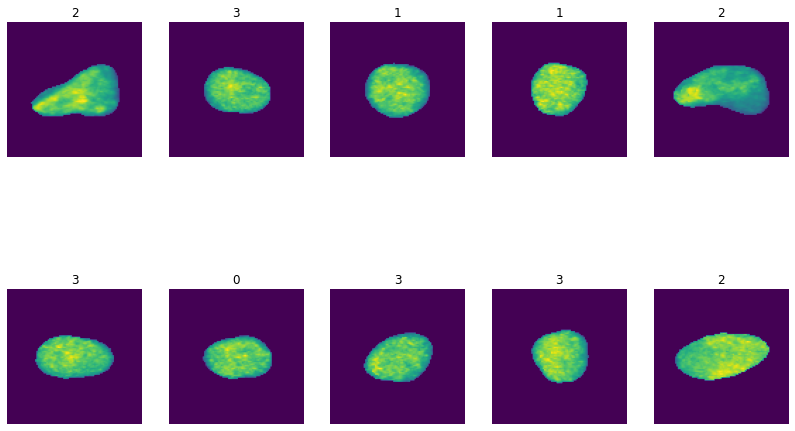

In [61]:
n_plot = 10
plt.figure(figsize=(14,9))
for i in range(n_plot):
    x = X_crop[i]
    y = prediction[i]
    plt.subplot(2,n_plot//2,i+1)
    plt.imshow(np.max(x.numpy(),(0,1)))
    plt.axis('off')
    plt.title(y)

In [15]:
ids = {k:v for k,v in zip(L_crop, pred)}
ids[0] = 0
print(ids)
print(len(ids))

{12: 2, 49: 3, 82: 1, 85: 1, 89: 2, 105: 3, 106: 0, 123: 3, 165: 3, 173: 2, 178: 1, 195: 3, 202: 1, 213: 1, 237: 0, 300: 3, 333: 2, 349: 0, 355: 3, 367: 2, 371: 0, 381: 3, 384: 0, 418: 2, 441: 2, 512: 3, 513: 1, 530: 3, 542: 2, 543: 2, 568: 1, 576: 3, 585: 2, 611: 0, 628: 2, 661: 2, 673: 3, 674: 2, 685: 1, 716: 2, 787: 2, 806: 2, 819: 2, 836: 3, 840: 2, 877: 2, 894: 1, 1017: 1, 1019: 2, 1054: 2, 1070: 1, 1091: 3, 1107: 3, 1119: 3, 1122: 1, 1178: 2, 1201: 2, 1291: 2, 1295: 2, 1325: 2, 1358: 2, 1360: 1, 1361: 1, 1428: 3, 1429: 2, 1469: 2, 1529: 1, 1595: 2, 1597: 1, 1609: 3, 1637: 3, 1649: 2, 1686: 1, 1706: 1, 1750: 1, 1877: 2, 1893: 2, 1913: 2, 1949: 2, 1974: 3, 1994: 2, 2011: 3, 2115: 3, 2132: 2, 2151: 2, 2218: 1, 2366: 2, 2497: 2, 2521: 4, 2538: 1, 2580: 2, 2629: 1, 2869: 1, 2885: 2, 3024: 2, 3088: 1, 3122: 1, 3241: 2, 7: 3, 40: 2, 48: 3, 63: 3, 66: 3, 75: 2, 77: 2, 78: 1, 83: 1, 104: 3, 119: 1, 145: 2, 170: 1, 171: 0, 175: 2, 177: 1, 199: 3, 225: 3, 243: 1, 251: 3, 286: 1, 295: 2, 301

In [21]:
dense_maps = []
for y in Y:
    mask = y
    m = mask.flatten()
    print(m)
    new_mask = []
    for i in range(len(m)):
        if m[i] not in ids:
            new_mask.append(8)
        else:
            new_mask.append(ids[m[i]])
    densemap = np.asarray(new_mask)
    densemap = np.reshape(densemap, y.shape)
    dense_maps.append(densemap)
    
#print(new_mask)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [32]:
import tifffile 

In [33]:
print(dense_maps[0].shape)
print(dense_maps[1].shape)

(61, 330, 300)
(61, 330, 300)


In [36]:
os.mkdir('class_predictions')

In [37]:
for densemap, name in zip(dense_maps, filenames):
    tifffile.imsave('class_predictions/'+ name, densemap)